## Macro Agent Based Model

In [7]:
import mesa
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
from scipy.stats import skew
from scipy.stats import linregress
from multiprocessing import freeze_support

### 1. Model definition

##### 1.1 Agents

- Firms

In [8]:
class Firm(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.production_Y = 1
        self.labor_productivity_alpha = 1
        self.desired_production_Yd = 0
        self.expected_demand_De = 1 
        self.desired_labor_force_Ld = 0
        self.my_employees = set()
        self.current_numbers_employees_L0 = 0
        self.number_of_vacancies_offered_V = 0
        self.minimum_wage_W_hat = 1
        self.wage_offered_Wb = self.minimum_wage_W_hat
        self.net_worth_A = 5
        self.total_payroll_W = 0
        self.loan_B = 0
        self.my_potential_banks = []
        self.my_bank = None
        self.inventory_S = 0
        self.individual_price_P = model.base_price
        self.revenue_R = 0
        self.gross_profits = 0
        self.net_profits = 0
        self.retained_profits_pi = 0
        self.amount_of_interest_to_pay = 0
        self.dividends_delta = model.dividends_delta
        self.size_replacing_firms = 0.2

- Households

In [ ]:
class Worker(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.employed = False
        self.my_firm = None
        self.contract = 0
        self.my_wage = 0
        self.income = 0
        self.savings = 1 + np.random.poisson(model.base_savings)
        self.wealth = 0
        self.propensity_to_consume_c = 1
        self.beta = model.beta 
        self.my_large_store = None  
        self.my_stores = [] 
        
    def get_hired(self, firm):
        self.employed = True
        self.my_firm = firm
        firm.my_employees.add(self)
        firm.current_numbers_employees_L0 += 1
        firm.number_of_vacancies_offered_V -= 1
        self.my_wage = firm.wage_offered_Wb
        self.income = self.my_wage 
        self.contract = 8 + np.random.poisson(10) 

- Banks

In [ ]:
class Bank(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.total_amount_of_credit_C = 0
        self.patrimonial_base_E = np.random.poisson(10000) + 10
        self.operational_interest_rate = 0
        self.my_borrowing_firms = []
        self.interest_rate_r = 0
        self.bad_debt_BD = 0
        self.bankrupt = False

##### 1.2 Model parameters and variables

In [ ]:
class EconomyModel(Model):
    def __init__(self, num_firms=64, num_workers=476, num_banks=10, base_price=1.5, base_savings=2, wage_shock=0.05, price_shock=0.015, interest_shock=0.01, production_shock=0.01,  interest_rate_policy_rbar = 0.05, base_wage = 1):
        super().__init__()
        self.num_firms = num_firms
        self.num_workers = num_workers
        self.num_banks = num_banks
        self.schedule = RandomActivation(self)
        self.base_price = base_price
        self.base_wage = base_wage
        self.base_savings = base_savings
        self.dividends_delta = 0.15
        self.beta = 0.87
        self.interest_rate_policy_rbar =interest_rate_policy_rbar
        self.credit_market_H = 2
        self.goods_market_M = 2
        self.labor_market_L = 2
        self.wage_shock = wage_shock
        self.price_shock = price_shock
        self.interest_shock = interest_shock
        self.production_shock = production_shock
        self.quarters_average_price = np.zeros(4)
        self.quarters_inflation = np.zeros(4)
        self.create_agents()
        self.datacollector = DataCollector(
                      model_reporters={
                "Unemployment Rate": lambda m: m.unemployment_rate(),
                "Net Worth of Firms": lambda m: m.net_worth_of_firms(),
                "Production of Firms": lambda m: m.production_of_firms(),
                 "Total Production of Firms": lambda m: sum(m.production_of_firms()),
                "Propensity to Consume": lambda m: m.calculate_propensity_to_consume(),
                "Quarterly Inflation": lambda m: m.quarterly_inflation(),
                "Annualized Inflation": lambda m: m.annualized_inflation(),
                "Desired Production": lambda m: m.desired_production(),
                "Nominal GDP": lambda m: m.nominal_gdp(),
                "Real GDP": lambda m: m.real_gdp(),
                "Consumption": lambda m: m.total_consumption(),
                "Price of Firms": lambda m: m.price_of_firms(),
                "Contractual Interest Rate": lambda m: m.contractual_interest_rate(),
                "Wage Offered": lambda m: m.wage_offered(),
                "Average Inflation": lambda m: m.average_inflation(),
                "Size of Firms": lambda m: m.size_of_firms(),
                "Wealth Distribution": lambda m: m.wealth_distribution(),
                "Wealth": lambda m: m.total_wealth(),
                "Vacancy Rate": lambda m: m.vacancy_rate(),
                 "Size of Firms": lambda m: m.size_of_firms(),
                "Bankrupt Firms": lambda m: sum(1 for firm in m.schedule.agents if isinstance(firm, Firm) and (firm.net_worth_A <= 0 or firm.production_Y <= 0)),
                "Bankrupt Banks": lambda m: sum(1 for bank in m.schedule.agents if isinstance(bank, Bank) and bank.patrimonial_base_E < 0),
                          
            },
                     agent_reporters={
                "Wealth": lambda a: getattr(a, 'wealth', 0),
                "Inventory-S": lambda a: getattr(a, 'inventory_S', None),
                 "Net_worth_A": lambda a: getattr(a, 'net_worth_A', None),
                "Income": lambda a: getattr(a, 'income', None),
                "Production_Y": lambda a: getattr(a, 'production_Y', None),
                "Banks Patrimonial Base": lambda a: getattr(a, 'patrimonial_base_E', None)
            }
)
        
    def unemployment_rate(self):
        unemployed = sum(1 for worker in self.schedule.agents if isinstance(worker, Worker) and not worker.employed)
        return unemployed / self.num_workers
    
    def net_worth_of_firms(self):
        return [firm.net_worth_A for firm in self.schedule.agents if isinstance(firm, Firm)]
    
    def vacancy_rate(self):
        total_vacancies = sum(firm.number_of_vacancies_offered_V for firm in self.schedule.agents if isinstance(firm, Firm))
        total_positions = sum(firm.current_numbers_employees_L0 + firm.number_of_vacancies_offered_V for firm in self.schedule.agents if isinstance(firm, Firm))
        if total_positions > 0:
            return (total_vacancies / total_positions) * 100  # by 100 to convert to percentage
        return 0


    def production_of_firms(self):
        return [firm.production_Y for firm in self.schedule.agents if isinstance(firm, Firm)]
    
    def desired_production(self):
        return [firm.desired_production_Yd for firm in self.schedule.agents if isinstance(firm, Firm)]
    
    def quarterly_inflation(self):
        if len(self.quarters_inflation) > 0:
            current_quarter_index = self.schedule.steps % 4
            return self.quarters_inflation[current_quarter_index]
        return 0  
    
    def annualized_inflation(self):

        if len(self.quarters_inflation) >= 4:
            inflation_factors = [(1 + q_infl / 100) for q_infl in self.quarters_inflation]
            annualized_factor = np.prod(inflation_factors)
            return (annualized_factor - 1) * 100
        return 0 
    
    def average_inflation(self):
        return np.mean(self.quarters_inflation) if len(self.quarters_inflation) > 0 else 0
    
    
    def nominal_gdp(self):
        return sum([firm.production_Y * firm.individual_price_P for firm in self.schedule.agents if isinstance(firm, Firm)])
    
    def real_gdp(self):
        base_price = 1.5  
        current_price = self.quarters_average_price[self.schedule.steps % 4]
        cpi = current_price / base_price * 100
        return self.nominal_gdp() / (cpi / 100)
         
    def total_consumption(self):
        return sum([max(0, worker.income - worker.savings) for worker in self.schedule.agents if isinstance(worker, Worker)])

    def price_of_firms(self):
        return [firm.individual_price_P for firm in self.schedule.agents if isinstance(firm, Firm)]
    
    def contractual_interest_rate(self):
        return np.mean([bank.operational_interest_rate for bank in self.schedule.agents if isinstance(bank, Bank)])
    
    def total_credit(self):
        return sum(bank.total_amount_of_credit_C for bank in self.schedule.agents if isinstance(bank, Bank))

    def wage_offered(self):
        return [firm.wage_offered_Wb for firm in self.schedule.agents if isinstance(firm, Firm)]
        
    def wealth_distribution(self):
        return [worker.wealth for worker in self.schedule.agents if isinstance(worker, Worker)]
    
    def total_wealth(self):
        return sum(worker.wealth for worker in self.schedule.agents if isinstance(worker, Worker))

    def size_of_firms(self):
    
        return {firm.unique_id: len(firm.my_employees) for firm in self.schedule.agents if isinstance(firm, Firm)}

    
    def calculate_propensity_to_consume(self):
        all_savings = [worker.savings for worker in self.schedule.agents if isinstance(worker, Worker) and worker.savings is not None]
        if not all_savings:
            return 0, 0, 0  

        average_savings = np.mean(all_savings)
        propensities = []

        for worker in self.schedule.agents:
            if isinstance(worker, Worker):
                savings_ratio = worker.savings / average_savings if average_savings > 0 else 0
         
                propensity = 1 / (1 + np.exp(-savings_ratio))
                propensities.append(propensity)

        return np.mean(propensities), np.min(propensities), np.max(propensities)
    
    def fn_minimum_wage_W_hat(self):
        annualized_inflation = (1 + sum(self.quarters_inflation) / 400) ** 4 - 1
        current_minimum_wage = min(firm.minimum_wage_W_hat for firm in self.schedule.agents if isinstance(firm, Firm))
        return current_minimum_wage * annualized_inflation
    
    def create_agents(self):
        
        for i in range(self.num_firms):
            firm = Firm(i, self)
            self.schedule.add(firm)          
        for i in range(self.num_workers):
            worker = Worker(i + self.num_firms, self)
            self.schedule.add(worker)    
        for i in range(self.num_banks):
            bank = Bank(i + self.num_firms + self.num_workers, self)
            self.schedule.add(bank)


    def step(self):
        self.firms_calculate_production()
        self.labor_market()
        self.credit_market()
        self.firms_produce()
        self.goods_market()
        self.firms_pay()
        self.firms_banks_survive()
        self.replace_bankrupt()
        self.datacollector.collect(self)
        self.schedule.step()

##### 1.3 Scheduling

In [ ]:
# Step 1:
    def firms_calculate_production(self):
        for agent in self.schedule.agents:
            if isinstance(agent, Firm):
              
                if agent.production_Y > 0:
                    min_price_Pl = (agent.total_payroll_W + agent.amount_of_interest_to_pay) / agent.production_Y
                else:
                    min_price_Pl = self.base_price  

                # Strategies:
                avg_market_price = np.mean([f.individual_price_P for f in self.schedule.agents if isinstance(f, Firm) and f.production_Y > 0])
                if agent.inventory_S == 0 and agent.individual_price_P >= avg_market_price:
                    agent.expected_demand_De = max(1, np.ceil(agent.production_Y * (1 + self.production_shock)))
                elif agent.inventory_S > 0 and agent.individual_price_P < avg_market_price:
                    agent.expected_demand_De = max(1, np.ceil(agent.production_Y * (1 - self.production_shock)))
                elif agent.inventory_S == 0 and agent.individual_price_P < avg_market_price:
                    agent.individual_price_P = max(min_price_Pl, agent.individual_price_P * (1 + self.price_shock))
                elif agent.inventory_S > 0 and agent.individual_price_P >= avg_market_price:
                    agent.individual_price_P = max(min_price_Pl, agent.individual_price_P * (1 - self.price_shock))

                agent.desired_production_Yd = agent.expected_demand_De
        self.update_economic_metrics()
        
        
    def update_economic_metrics(self):
        current_prices = [f.individual_price_P for f in self.schedule.agents if isinstance(f, Firm) and f.production_Y > 0]
        current_quarter_index = self.schedule.steps % 4
        self.quarters_average_price[current_quarter_index] = np.mean(current_prices)
        if self.schedule.steps > 0:
            previous_quarter_index = (self.schedule.steps - 1) % 4
            previous_price = self.quarters_average_price[previous_quarter_index]
            current_price = self.quarters_average_price[current_quarter_index]
            if previous_price > 0:
                inflation = ((current_price - previous_price) / previous_price) * 100
            else:
                inflation = 0
            self.quarters_inflation[current_quarter_index] = inflation


# Step 2
    def labor_market(self):
        for agent in self.schedule.agents:
            if isinstance(agent, Firm):
                
                if self.schedule.steps > 0 and self.schedule.steps % 4 == 0:
                    law_minimum_wage = self.fn_minimum_wage_W_hat()
                else:
                    law_minimum_wage = self.base_wage  

                
                if agent.labor_productivity_alpha != 0:
                    agent.desired_labor_force_Ld = np.ceil(agent.desired_production_Yd / agent.labor_productivity_alpha)
                else:
                    agent.desired_labor_force_Ld = 0
                
                agent.current_numbers_employees_L0 = len(agent.my_employees)
                agent.number_of_vacancies_offered_V = max(agent.desired_labor_force_Ld - agent.current_numbers_employees_L0, 0)

            
                if self.schedule.steps % 4 == 0:
                    agent.minimum_wage_W_hat = law_minimum_wage
                
                if agent.number_of_vacancies_offered_V > 0:
                    agent.wage_offered_Wb = max(agent.minimum_wage_W_hat, agent.wage_offered_Wb * (1 + self.wage_shock))   
                else:
                    agent.wage_offered_Wb = max(agent.minimum_wage_W_hat, agent.wage_offered_Wb)
        self.labor_market_opens()

    def labor_market_opens(self):
        if any(isinstance(agent, Firm) and agent.number_of_vacancies_offered_V > 0 for agent in self.schedule.agents):
            self.hiring_step(self.labor_market_L)
            
            
        for worker in [w for w in self.schedule.agents if isinstance(w, Worker) and not w.employed]:
            worker.my_wage = 0
            worker.income = 0
                    
    def hiring_step(self, trials):
        for _ in range(trials):
            for worker in [w for w in self.schedule.agents if isinstance(w, Worker) and not w.employed]:
                potential_firms = [f for f in self.schedule.agents if isinstance(f, Firm) and f.number_of_vacancies_offered_V > 0]
                if potential_firms:
                    chosen_firm = max(potential_firms, key=lambda f: f.wage_offered_Wb)
                    worker.get_hired(chosen_firm)


# Step 3
    def credit_market(self):
        
        for agent in self.schedule.agents:
            if isinstance(agent, Bank):
                agent.total_amount_of_credit_C = agent.patrimonial_base_E / self.credit_market_H
                agent.operational_interest_rate = random.uniform(self.interest_rate_policy_rbar, self.interest_rate_policy_rbar + self.interest_shock)


        for agent in self.schedule.agents:
            if isinstance(agent, Firm) and agent.production_Y > 0 and agent.total_payroll_W > agent.net_worth_A:
                leverage = agent.desired_production_Yd * agent.wage_offered_Wb
                agent.loan_B = max(leverage - agent.net_worth_A, 0)
            
        self.credit_market_opens()
        self.firing_step()

    def credit_market_opens(self):
        for agent in self.schedule.agents:
            if isinstance(agent, Firm) and agent.loan_B > 0:
                potential_banks = [bank for bank in self.schedule.agents if isinstance(bank, Bank)]
                random.shuffle(potential_banks)  
                potential_banks = potential_banks[:self.credit_market_H]
                for bank in potential_banks:
                    if bank.total_amount_of_credit_C > 0:
                        self.lending_step(bank, agent)

    def lending_step(self, bank, firm):
        loan_amount = min(firm.loan_B, bank.total_amount_of_credit_C)
        interest_rate = self.interest_rate_policy_rbar * (1 + (bank.operational_interest_rate * (firm.loan_B / max(firm.net_worth_A, 1))))
        borrowing_cost = loan_amount * (1 + interest_rate)
        firm.my_bank = bank
        firm.my_interest_rate = interest_rate
        firm.amount_of_interest_to_pay = loan_amount * (1 + interest_rate)
        firm.net_worth_A += loan_amount
        firm.loan_B -= loan_amount
        bank.total_amount_of_credit_C -= loan_amount
        firm.production_Y -= borrowing_cost

    def firing_step(self):
        for agent in self.schedule.agents:
            if isinstance(agent, Firm):
                while agent.total_payroll_W > agent.net_worth_A and len(agent.my_employees) > 1:
                    expensive_worker = max(agent.my_employees, key=lambda x: x.my_wage)
                    agent.my_employees.remove(expensive_worker)
                    agent.total_payroll_W -= expensive_worker.my_wage
                    expensive_worker.employed = False
                    expensive_worker.my_wage = 0
                    expensive_worker.income = 0
                    expensive_worker.contract = 0
                    expensive_worker.my_firm = None

# Step 4
    def firms_produce(self):
        
        for agent in self.schedule.agents:
            if isinstance(agent, Firm):
                agent.production_Y = agent.labor_productivity_alpha * len(agent.my_employees)
                agent.inventory_S = agent.production_Y * agent.individual_price_P
                agent.net_worth_A -= agent.total_payroll_W  

        for agent in self.schedule.agents:
            if isinstance(agent, Worker) and agent.employed:
                agent.income = agent.my_wage
                agent.contract -= 1
                if agent.contract <= 0:
                    self.terminate_employment(agent)

       
        for agent in self.schedule.agents:
            if isinstance(agent, Firm):
                agent.my_employees = {emp for emp in agent.my_employees if emp.contract > 0}

    def terminate_employment(self, worker):
 
        worker.employed = False
        worker.my_wage = 0
        worker.income = 0
        if worker.my_firm:
            worker.my_firm.my_employees.discard(worker)
        worker.my_firm = None


# Step 5
    def goods_market(self):
    
        all_workers = [agent for agent in self.schedule.agents if isinstance(agent, Worker)]
        average_savings = np.mean([worker.savings for worker in all_workers])

  
        for worker in all_workers:
            worker.wealth = worker.income + worker.savings
            
            if average_savings <= 0:
                worker.propensity_to_consume_c = 1
            else:
                savings_ratio = worker.savings / average_savings
                tanh_value = np.tanh(savings_ratio)
                tanh_value = np.abs(tanh_value) ** self.beta

                worker.propensity_to_consume_c = 1 / (1 + tanh_value)
            
            money_to_consume = worker.propensity_to_consume_c * worker.wealth
            worker.savings = worker.wealth - money_to_consume 
        
           
            available_firms = [agent for agent in self.schedule.agents if isinstance(agent, Firm)]
            if worker.my_large_store:
                other_firms = [firm for firm in available_firms if firm != worker.my_large_store]
                worker.my_stores = random.sample(other_firms, min(self.goods_market_M - 1, len(other_firms)))
                worker.my_stores.append(worker.my_large_store)
            else:
                worker.my_stores = random.sample(available_firms, min(self.goods_market_M, len(available_firms)))

    
            worker.my_large_store = max(worker.my_stores, key=lambda x: x.production_Y, default=None)
            self.buying_step(worker, money_to_consume)

    def buying_step(self, worker, money):
       
        trials = self.goods_market_M
        while trials > 0 and money > 0:
            if worker.my_stores:
                cheapest_store = min(worker.my_stores, key=lambda x: x.individual_price_P)
                possible_goods_to_buy = min(money / cheapest_store.individual_price_P, cheapest_store.inventory_S)
                money_spent = possible_goods_to_buy * cheapest_store.individual_price_P
                cheapest_store.inventory_S -= possible_goods_to_buy
                money -= money_spent
                trials -= 1
                worker.my_stores = [store for store in worker.my_stores if store != cheapest_store]
        worker.savings += money

# Step 6
    def firms_pay(self):
       
        for agent in self.schedule.agents:
            if isinstance(agent, Firm):
                agent.revenue_R = agent.individual_price_P * (agent.production_Y - agent.inventory_S)
                agent.gross_profits = agent.revenue_R - agent.total_payroll_W
                principal_and_interest = agent.amount_of_interest_to_pay

                if principal_and_interest > 0:
                    if agent.gross_profits > principal_and_interest:
                       
                        if agent.my_bank:
                            agent.my_bank.patrimonial_base_E += principal_and_interest
                    else:
                       
                        bank_financing = (agent.loan_B / agent.net_worth_A) if agent.net_worth_A != 0 else 1
                        bad_debt_amount = bank_financing * agent.net_worth_A
                        if agent.my_bank:
                            agent.my_bank.patrimonial_base_E -= bad_debt_amount

         
                agent.net_profits = agent.gross_profits - principal_and_interest
                agent.amount_of_interest_to_pay = 0 
            
                if agent.net_profits > 0:
                    agent.retained_profits_pi = (1 - self.dividends_delta) * agent.net_profits
                else:
                    agent.retained_profits_pi = 0

            
                agent.net_worth_A += agent.retained_profits_pi
        
        
# Step 7
    def firms_banks_survive(self):
        for agent in list(self.schedule.agents):
            if isinstance(agent, Firm):
                agent.net_worth_A += agent.retained_profits_pi  
                if agent.net_worth_A <= 0 or agent.production_Y <= 0:
                    if agent.my_bank:
                        agent.my_bank.bad_debt_BD += 1  
               
                    for employee in list(agent.my_employees):
                        self.terminate_employment(employee)
                    self.schedule.remove(agent)  

        for agent in list(self.schedule.agents):
            if isinstance(agent, Bank) and agent.patrimonial_base_E < 0:
        
                for firm in agent.my_borrowing_firms:
                    firm.my_bank = None  
                agent.bankrupt = True
                self.schedule.remove(agent)  

            
# Step 8
    def replace_bankrupt(self):
      
        all_firms = [agent for agent in self.schedule.agents if isinstance(agent, Firm)]
        if all_firms:
       
            incumbent_firms = self.fn_incumbent_firms()
            if incumbent_firms:
                new_firms_production_Y = np.ceil(np.mean([firm.production_Y for firm in incumbent_firms]))
                new_firms_minimum_wage_W_hat = min(firm.minimum_wage_W_hat for firm in incumbent_firms)
                new_firms_wage_offered_Wb = (1 - self.size_replacing_firms) * np.mean([firm.wage_offered_Wb for firm in incumbent_firms])
                new_firms_net_worth_A = (1 - self.size_replacing_firms) * np.mean([firm.net_worth_A for firm in incumbent_firms])
                average_market_price = np.mean([firm.individual_price_P for firm in incumbent_firms])
                new_firms_individual_price_P = 1.26 * average_market_price

     
                num_new_firms = self.num_firms - len(all_firms)
                for _ in range(num_new_firms):
                    new_firm_id = max(firm.unique_id for firm in all_firms) + 1
                    new_firm = Firm(new_firm_id, self, new_firms_production_Y, new_firms_minimum_wage_W_hat,
                                    new_firms_wage_offered_Wb, new_firms_net_worth_A, new_firms_individual_price_P)
                    self.schedule.add(new_firm)


        all_banks = [agent for agent in self.schedule.agents if isinstance(agent, Bank)]
        for bank in list(all_banks):
            if bank.bankrupt:
                # Reset bank attributes
                bank.total_amount_of_credit_C = 0
                bank.patrimonial_base_E = np.random.poisson(10000) + 10
                bank.operational_interest_rate = 0
                bank.interest_rate_r = 0
                bank.my_borrowing_firms = set()
                bank.bankrupt = False

    def fn_incumbent_firms(self):
        all_firms = [agent for agent in self.schedule.agents if isinstance(agent, Firm)]
        sorted_firms = sorted(all_firms, key=lambda x: x.net_worth_A, reverse=True)
        num_to_select = int(len(sorted_firms) * 0.2)
        

### 2. Simulation


In [194]:
original_model = EconomyModel()

num_steps = 200

for i in range(num_steps):
    original_model.step()

original_data = original_model.datacollector.get_model_vars_dataframe()
original_agents = original_model.datacollector.get_agent_vars_dataframe()

## 3. Macroeconomic signals validation

#### 3.1 Unemployment rate

0.118
0.062
The mean unemployment is 12.0% 
The median unemployment is 6.0% 


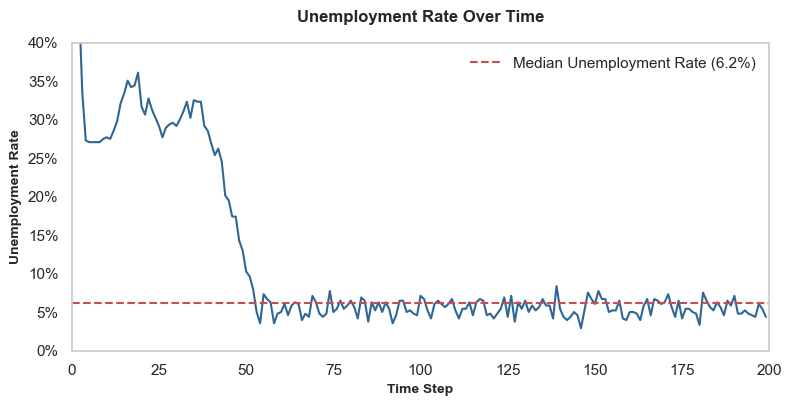

In [196]:
original_unemployment = original_model.datacollector.get_model_vars_dataframe()['Unemployment Rate']

avg = np.mean(original_unemployment)
print(round(avg,3))
median = np.median(original_unemployment)
print(round(median,3))
max_unemployment = np.max(original_unemployment)
min_unemployment = np.min(original_unemployment)

print(f"The mean unemployment is {100*round(avg,2)}% ")
print(f"The median unemployment is {100*round(median,2)}% ")


plt.figure(figsize=(9, 4))
plt.plot(original_unemployment, color='#2f6694')
x_ticks = np.arange(0, 250, 50) 
plt.axhline(y=median, color='r', linestyle='--', label=f'Median Unemployment Rate ({100*round(median,3)}%)')
plt.xlabel('Time Step', fontsize=10, fontweight='bold')
plt.ylabel('Unemployment Rate', fontsize=10, fontweight='bold')
plt.title('Unemployment Rate Over Time', fontsize=12, fontweight='bold',pad=15)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
plt.xlim(0, 200)
plt.ylim(0, 0.4)
plt.grid(False)
plt.legend(frameon=False)
plt.savefig('unemployment_plot.png') 
plt.show()

#### 3.2 Real GDP - log

1359.29025563973
The mean Nominal GDP  is 7.02 


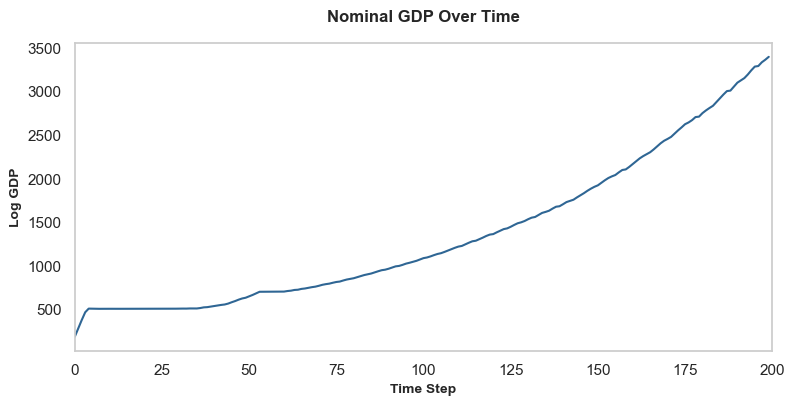

In [197]:
avg_gdp = np.mean(original_data["Nominal GDP"])
print(avg_gdp)
log_nom_gdp_original = np.log(original_data["Nominal GDP"])

avg_log_gdp = np.mean(log_nom_gdp_original) 
print(f"The mean Nominal GDP  is {round(avg_log_gdp,2)} ")


plt.figure(figsize=(9, 4))
plt.plot(original_data["Nominal GDP"], color='#2f6694')
plt.xlabel('Time Step', fontsize=10, fontweight='bold')
plt.ylabel('Log GDP',fontsize=10, fontweight='bold')
plt.title('Nominal GDP Over Time',fontsize=12, fontweight='bold',pad=15)
plt.xlim(0,200)
plt.grid(False)
plt.savefig('nominal_gdp.png') 
plt.show()

713.7996633041039
The mean Real GDP  is 6.49 


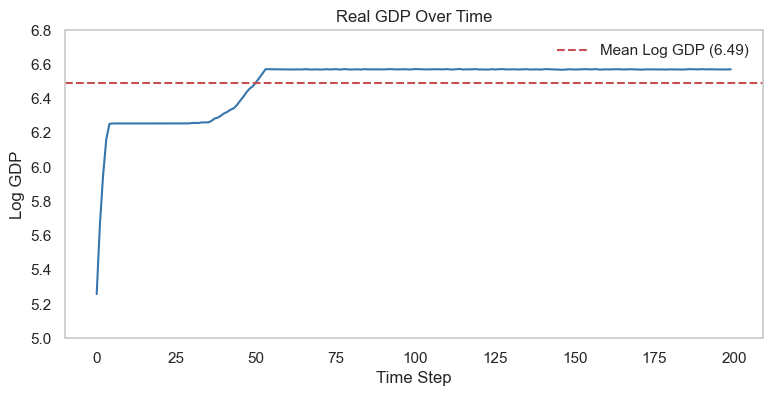

In [198]:
avg_gdp = np.median(original_data["Real GDP"])
print(avg_gdp)
log_real_gdp_original = np.log(original_data["Real GDP"])

avg_log_gdp = np.mean(log_real_gdp_original) 
print(f"The mean Real GDP  is {round(avg_log_gdp,2)} ")

plt.figure(figsize=(9, 4))
plt.plot(log_real_gdp_original, color='#3776ab')
plt.axhline(y=avg_log_gdp, color='r', linestyle='--', label=f'Mean Log GDP ({round(avg_log_gdp,2)})') 
plt.xlabel('Time Step')
#plt.xlim(0, 200) 
plt.ylim(5,6.8)
plt.ylabel('Log GDP')
plt.title('Real GDP Over Time')
legend = plt.legend()  # Show the legend to explain the plot elements
legend.get_frame().set_edgecolor('none')  # Remove the border
legend.get_frame().set_facecolor('none')  
plt.grid(False)
plt.show()



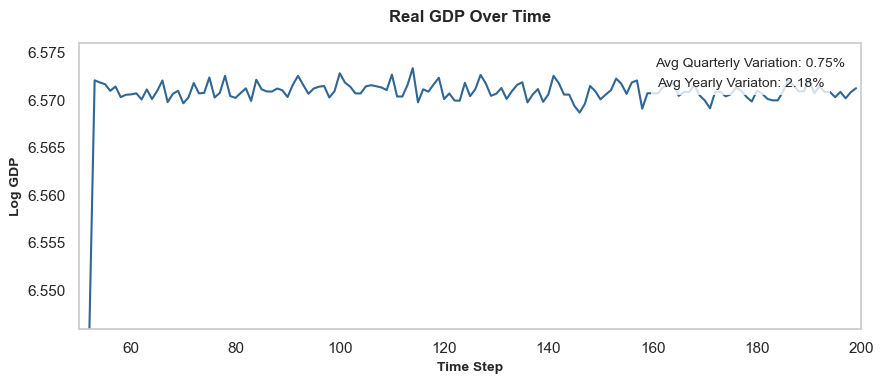

In [199]:
import matplotlib.pyplot as plt


real_gdp = original_data["Real GDP"]
gdp_growth_rate = real_gdp.pct_change(periods=4) * 100
quarter_gdp_growth_rate = real_gdp.pct_change(periods=1) * 100

mean_gdp_growth_rate = np.mean(gdp_growth_rate)
mean_quarter_gdp_growth_rate = np.mean(quarter_gdp_growth_rate)


plt.figure(figsize=(9, 4))
plt.plot(log_real_gdp_original, color='#2f6694')
x_ticks = np.arange(0, 250, 20) 
#plt.xticks(x_ticks, x_ticks - 20)

plt.text(0.98, 0.95, f'Avg Quarterly Variation: {mean_quarter_gdp_growth_rate:.2f}%', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
plt.text(0.953, 0.88, f'Avg Yearly Variaton: {mean_gdp_growth_rate:.2f}%', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

plt.xlabel('Time Step', fontsize=10, fontweight='bold')
plt.ylabel('Log GDP', fontsize=10, fontweight='bold')
plt.title('Real GDP Over Time', fontsize=12, fontweight='bold',pad=15)
plt.xlim(50, len(log_real_gdp_original))  
plt.ylim(min(log_real_gdp_original[52:]), 6.576) 
plt.grid(False)
plt.tight_layout() 
plt.savefig('gdp_growth.png') 
plt.show()

#### 3.3 Quarter and year GDP growth rate

In [200]:
import matplotlib.pyplot as plt
import numpy as np

real_gdp = original_data["Real GDP"]

gdp_growth_rate = real_gdp.pct_change(periods=4) * 100
quarter_gdp_growth_rate = real_gdp.pct_change(periods=1) * 100
print(f'{round(np.mean(gdp_growth_rate),2)}% annual growth rate of Real GDP')
print(f'{round(np.mean(quarter_gdp_growth_rate),2)}% quarterly growth rate of Real GDP')


2.18% annual growth rate of Real GDP
0.75% quarterly growth rate of Real GDP


#### 3.4 Wealth Distribution

In [201]:
income = original_agents["Income"]
end_income = income.xs(99, level="Step")  
print(end_income.head())  
end_income = end_income.dropna()  

wealth = original_agents["Wealth"]
end_wealth = wealth.xs(99, level="Step")  
print(end_wealth.head())  
end_wealth = end_wealth.dropna()  


income_skewness = skew(end_income.dropna()) 
print("Skewness of income distribution:", income_skewness)
wealth_skewness = skew(end_wealth.dropna()) 
print("Skewness of wealth distribution:", wealth_skewness)

AgentID
486     7.039989
126    19.613145
69     21.623493
513    13.274949
92      0.000000
Name: Income, dtype: float64
AgentID
486     73.706825
126    194.290141
69     241.585302
513    169.966757
92     101.606919
Name: Wealth, dtype: float64
Skewness of income distribution: 0.560879074526372
Skewness of wealth distribution: 0.04796588851805281


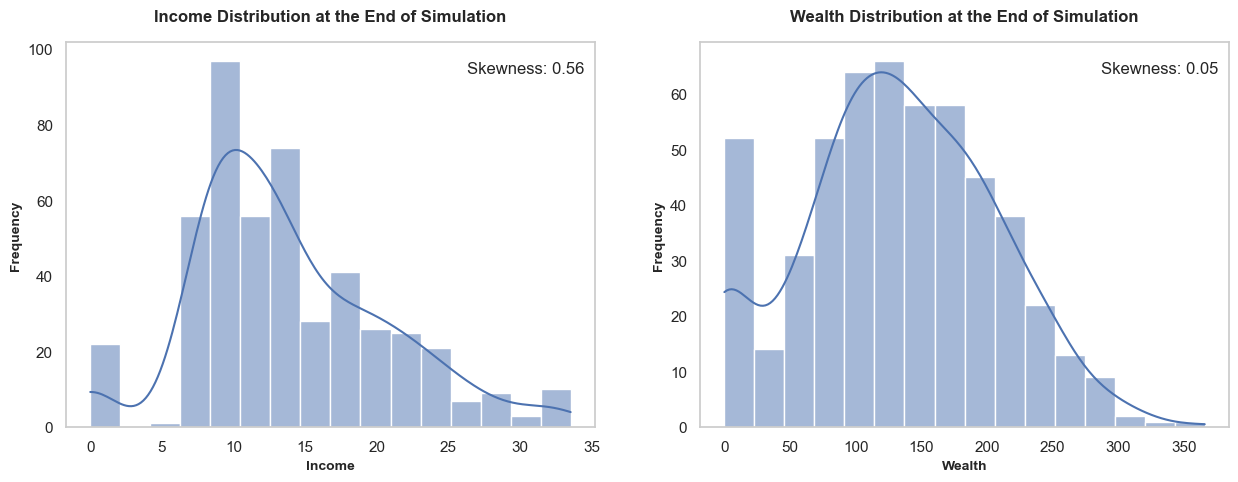

In [202]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))  

plt.subplot(1, 2, 1)
sns.histplot(end_income, kde=True)
plt.title('Income Distribution at the End of Simulation', fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Income', fontsize=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=10, fontweight='bold')
plt.text(0.98, 0.95, f'Skewness: {round(income_skewness, 2)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
plt.grid(False)

plt.subplot(1, 2, 2)
sns.histplot(end_wealth, kde=True)
plt.title('Wealth Distribution at the End of Simulation', fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Wealth', fontsize=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=10, fontweight='bold')
plt.text(0.98, 0.95, f'Skewness: {round(wealth_skewness, 2)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
plt.grid(False)
plt.savefig('wealth_distribution.png') 
plt.show()

#### 3.5 Firms net worth and size distribution

Skewness of Net Worth: 1.32
Skewness of Firms Size -0.7


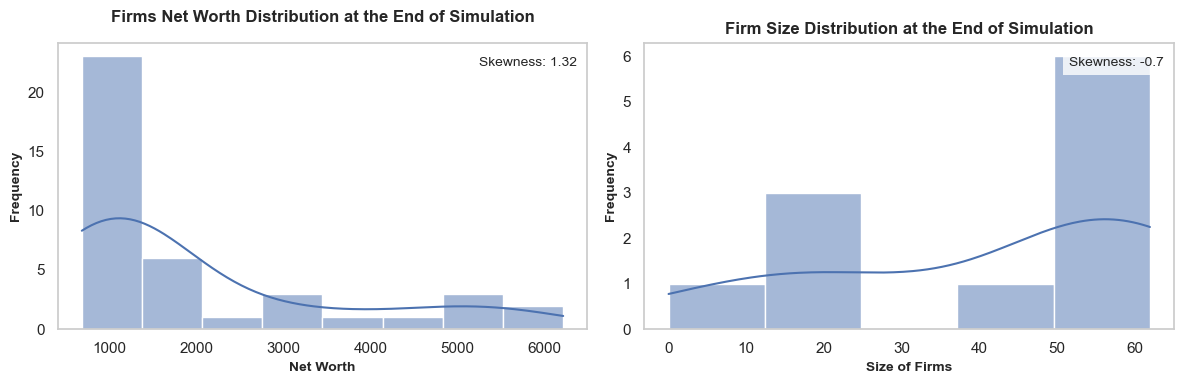

In [203]:
# Net Worth of Firms
worth_firms = original_agents['Net_worth_A'].dropna()
end_worth_firms = worth_firms.xs(99, level="Step")
end_worth_firms = end_worth_firms.dropna()
worth_skewness = skew(end_worth_firms.dropna())
mean_value_net_worth = np.mean(end_worth_firms)

# Size of firms
firms_size = original_model.datacollector.get_model_vars_dataframe()["Size of Firms"]
last_firm_sizes = firms_size.iloc[-1] 
sizes = list(last_firm_sizes.values())
mean_value_sizes = np.mean(sizes)

worth_skewness = skew(end_worth_firms.dropna()) 
print("Skewness of Net Worth:", round(worth_skewness,2))

sizes_skewness = skew(sizes)
print("Skewness of Firms Size", round(sizes_skewness,2))


sns.set(style="whitegrid")
plt.figure(figsize=(12, 4))

# First subplot: Firms Net Worth Distribution
plt.subplot(1, 2, 1)
sns.histplot(end_worth_firms, kde=True, bins = 8, edgecolor='w')
plt.title('Firms Net Worth Distribution at the End of Simulation', fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Net Worth', fontsize=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=10, fontweight='bold')
plt.text(0.98, 0.95, f'Skewness: {round(worth_skewness, 2)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
plt.grid(False)

# Second subplot: Firm Size Distribution
plt.subplot(1, 2, 2)
sns.histplot(sizes,  kde=True, edgecolor='w') 
plt.title('Firm Size Distribution at the End of Simulation', fontsize=12, fontweight='bold')
plt.xlabel('Size of Firms',fontsize=10, fontweight='bold')
plt.ylabel('Frequency',fontsize=10, fontweight='bold')
plt.text(0.98, 0.95, f'Skewness: {round(sizes_skewness, 2)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
plt.grid(False)

plt.tight_layout()
plt.show()


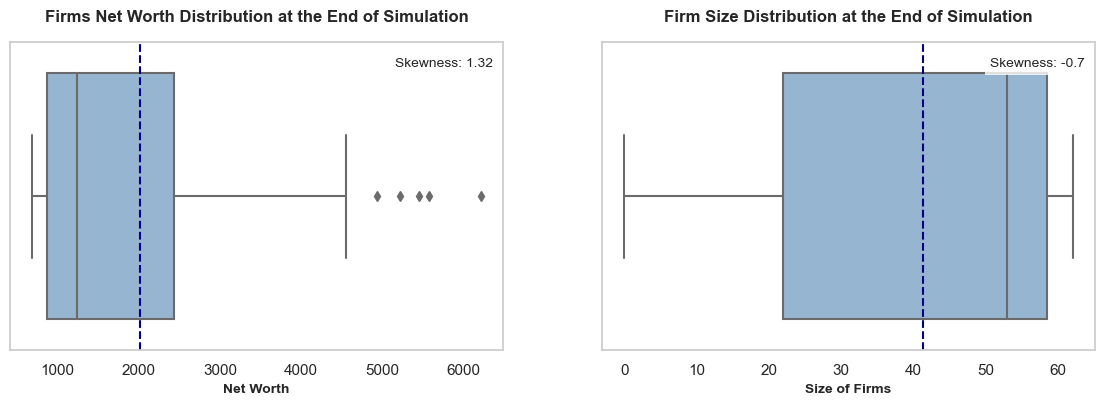

Skewness of Net Worth: 1.32
Skewness of Firms Size -0.7


In [204]:
plt.figure(figsize=(14, 4))

# First subplot for Net Worth
plt.subplot(1,2,1)
bp1 = sns.boxplot(x=end_worth_firms, color='#8cb6da')
plt.axvline(mean_value_net_worth, color='navy', linestyle='--', label='Mean') 
plt.title('Firms Net Worth Distribution at the End of Simulation', fontsize=12, fontweight='bold', pad=15)
plt.xlabel('Net Worth', fontsize=10, fontweight='bold')
plt.text(0.98, 0.95, f'Skewness: {round(worth_skewness, 2)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
plt.grid(False) 

# Second subplot for Sizes
plt.subplot(1,2,2)
bp2 = sns.boxplot(x=sizes, color='#8cb6da')
mean_value_sizes = np.mean(sizes)
plt.axvline(mean_value_sizes, color='navy', linestyle='--')
plt.title('Firm Size Distribution at the End of Simulation', fontsize=12, fontweight='bold', pad=15)
plt.xlabel('Size of Firms', fontsize=10, fontweight='bold')
plt.text(0.98, 0.95, f'Skewness: {round(sizes_skewness, 2)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
plt.grid(False) 


plt.savefig('wealth_boxplot.png') 
plt.show()



worth_skewness = skew(end_worth_firms.dropna()) 
print("Skewness of Net Worth:", round(worth_skewness,2))

sizes_skewness = skew(sizes)
print("Skewness of Firms Size", round(sizes_skewness,2))

#### 3.6 Inflation rate

In [9]:
Annualized_inflation = original_data['Annualized Inflation']
Quarter_inflation = original_data['Quarterly Inflation']

mean_annualized = np.mean(original_data['Annualized Inflation'])
print(f'The annualized inflation is {round(mean_annualized,1)}%')
mean_quarter = np.mean(original_data['Quarterly Inflation'])
print(f'The quarterly inflation is {round(mean_quarter,1)}%')
quarters = np.arange(num_steps)
years = quarters / 4  # Convert quarters to years

plt.figure(figsize=(9, 4))
plt.plot(years, original_data['Annualized Inflation'],  color='#2f6694', label=f'Avg inflation: {round(mean_annualized, 2)}%')
plt.title('Annualized Inflation Over Simulation Period', fontsize=12, fontweight='bold', pad=15)
plt.xlabel('Years', fontsize=10, fontweight='bold')
plt.xlim(0,50)
plt.ylabel('Inflation (%)',fontsize=10, fontweight='bold')
plt.grid(False)
plt.legend(frameon=False)
plt.savefig('inflation.png') 
plt.show()

NameError: name 'original_data' is not defined

### 4. Crises simulation

#### 4.1 Contractionary monetary policy: Interest rate increase

In [6]:
rate_shocked_model = EconomyModel(num_firms=64, num_workers=476, num_banks=10, base_price=1.5, base_savings=2, wage_shock=0.05, price_shock=0.01, interest_shock=0.9, interest_rate_policy_rbar = 0.5, production_shock=0.01)

for i in range(num_steps):
    rate_shocked_model.step()

    
rate_shocked_model_data = rate_shocked_model.datacollector.get_model_vars_dataframe()
rate_shocked_agent_data = rate_shocked_model.datacollector.get_agent_vars_dataframe()

NameError: name 'EconomyModel' is not defined

**a) Effect on GDP**

In [207]:
gdp_original = original_data["Real GDP"]
print(gdp_original)

real_gdp_shock = rate_shocked_model_data["Real GDP"]
print(real_gdp_shock)

avg_gdp = np.max(gdp_original) 
print(f"The mean Real GDP in the original model is {avg_gdp,2} ")

avg_gdp_shock = np.max(real_gdp_shock) 
print(f"The mean Real GDP in the shocked is {avg_gdp_shock,2} ")

0      192.000000
1      288.000000
2      384.000000
3      474.084454
4      519.341009
          ...    
195    713.581564
196    713.977810
197    713.497621
198    713.957169
199    714.253984
Name: Real GDP, Length: 200, dtype: float64
0      192.000000
1      288.000000
2      382.514768
3      466.618273
4      510.182949
          ...    
195    713.881644
196    714.328756
197    713.845105
198    713.877594
199    713.879995
Name: Real GDP, Length: 200, dtype: float64
The mean Real GDP in the original model is (715.757317886947, 2) 
The mean Real GDP in the shocked is (715.3814861408933, 2) 


The maximum Real GDP in the original model is 8.132038705861838
The maximum Real GDP in the shocked model is 7.604381289793461


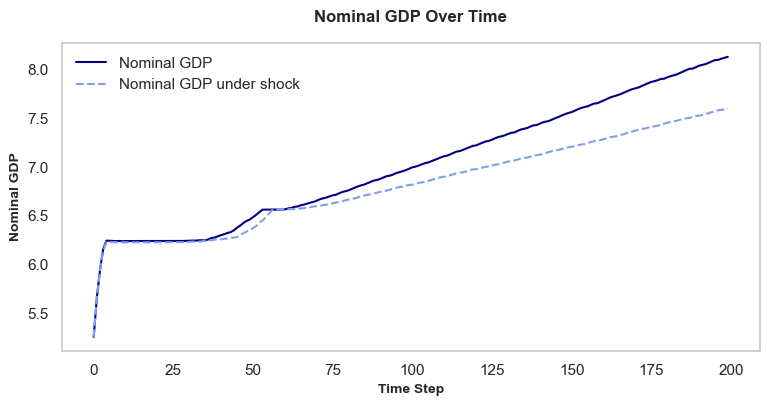

In [208]:
log_real_gdp_original = np.log(original_data["Nominal GDP"])
log_real_gdp_shock = np.log(rate_shocked_model_data["Nominal GDP"])

max_log_gdp_original = np.max(log_real_gdp_original)
max_log_gdp_shock = np.max(log_real_gdp_shock)

print(f"The maximum Real GDP in the original model is {max_log_gdp_original}")
print(f"The maximum Real GDP in the shocked model is {max_log_gdp_shock}")

plt.figure(figsize=(9, 4))

# Plot
plt.plot(log_real_gdp_original, label='Nominal GDP', color='navy')
plt.plot(log_real_gdp_shock, label='Nominal GDP under shock', linestyle='--',color='#819EF0')
plt.xlabel('Time Step', fontsize=10, fontweight='bold')
plt.grid(False)
plt.ylabel('Nominal GDP', fontsize=10, fontweight='bold')
plt.title('Nominal GDP Over Time', fontsize=12, fontweight='bold',pad=15)
plt.legend(frameon = False)

plt.savefig('gdp_comparison.png') 
plt.show()

The maximum Real GDP in the original model is 6.573341168008316
The maximum Real GDP in the shocked model is 6.572815947458589


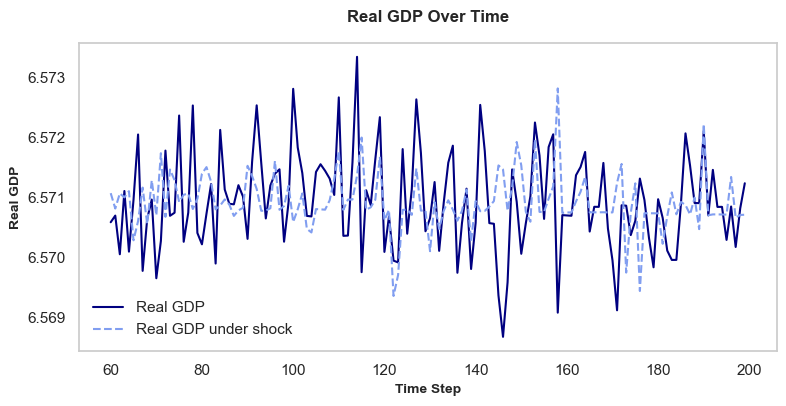

In [209]:
log_real_gdp_original = np.log(original_data["Real GDP"])
log_real_gdp_shock = np.log(rate_shocked_model_data["Real GDP"])

max_log_gdp_original = np.max(log_real_gdp_original)
max_log_gdp_shock = np.max(log_real_gdp_shock)

print(f"The maximum Real GDP in the original model is {max_log_gdp_original}")
print(f"The maximum Real GDP in the shocked model is {max_log_gdp_shock}")

plt.figure(figsize=(9, 4))

# Plot
plt.plot(log_real_gdp_original[60:], label='Real GDP', color='navy')
plt.plot(log_real_gdp_shock[60:], label='Real GDP under shock', linestyle = '--', color='#819EF0')
plt.xlabel('Time Step',fontsize=10, fontweight='bold')
plt.grid(False)
plt.ylabel('Real GDP',fontsize=10, fontweight='bold')
plt.title('Real GDP Over Time',  fontsize=12, fontweight='bold',pad=15)
plt.legend(frameon = False)

plt.savefig('real_gdp_comparison.png') 
plt.show()

**b) Effect on inflation**

The annualized inflation for the original model is 3.16%
The annualized inflation for the comparison model is 2.08%


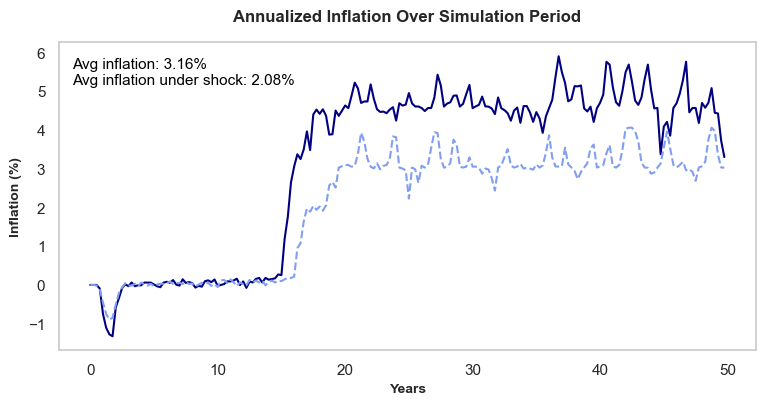

In [210]:
# Calculate mean annualized inflation for both models
mean_annualized_original = np.mean(original_data['Annualized Inflation'])
mean_annualized_comparison = np.mean(rate_shocked_model_data['Annualized Inflation'])

# Print mean values
print(f'The annualized inflation for the original model is {round(mean_annualized_original, 2)}%')
print(f'The annualized inflation for the comparison model is {round(mean_annualized_comparison, 2)}%')

# Convert quarters to years
num_steps = len(original_data)
quarters = np.arange(num_steps)
years = quarters / 4  # Convert quarters to years

# Plot annualized inflation for both models
plt.figure(figsize=(9, 4))
plt.plot(years, original_data['Annualized Inflation'], color='navy')
plt.plot(years, rate_shocked_model_data['Annualized Inflation'], linestyle = '--', color='#819EF0')
plt.title('Annualized Inflation Over Simulation Period',  fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Years',fontsize=10, fontweight='bold')
plt.ylabel('Inflation (%)',fontsize=10, fontweight='bold')
plt.grid(False)

plt.text(0.02, 0.95, f'Avg inflation: {round(mean_annualized_original, 2)}%', 
         ha='left', va='top', transform=plt.gca().transAxes, fontsize=11, color='black')
plt.text(0.02, 0.90, f'Avg inflation under shock: {round(mean_annualized_comparison, 2)}%', 
         ha='left', va='top', transform=plt.gca().transAxes, fontsize=11, color='black')


plt.savefig('inflation_comparison.png') 
plt.show() 

**c) Effect on wages:**

In [211]:
wage_data_original = original_data['Wage Offered']
wage_data_shocked = rate_shocked_model_data['Wage Offered']


mean_wage_original = [np.mean(wages) for wages in wage_data_original]

mean_wage_shocked = [np.mean(wages) for wages in wage_data_shocked]

overall_mean_wage_original = np.mean(mean_wage_original)
overall_mean_wage_shocked = np.mean(mean_wage_shocked)
print(f"The average offered wage in the original model is {overall_mean_wage_original}")
print(f"The average offered wage in the shocked model is {overall_mean_wage_shocked}")

The average offered wage in the original model is 192.09189845816735
The average offered wage in the shocked model is 112.71842918997821


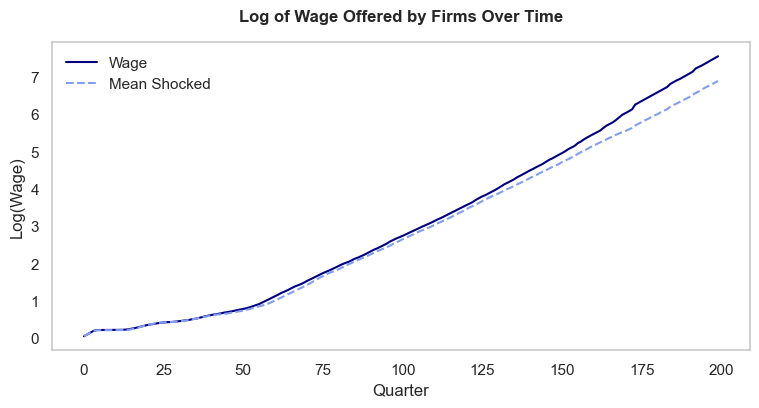

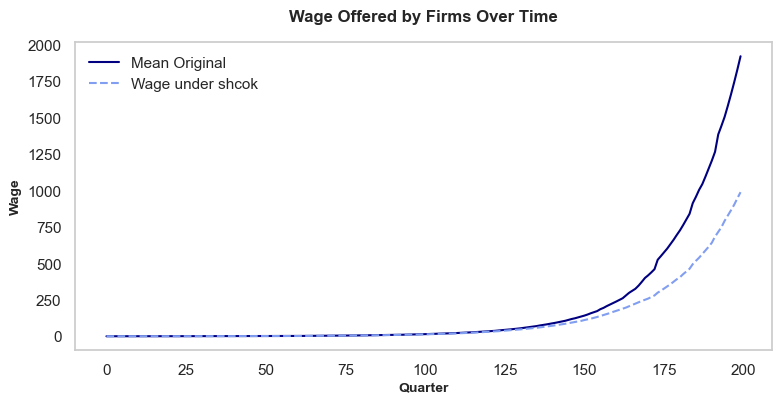

In [212]:

log_mean_wage_original = np.log(mean_wage_original)
log_mean_wage_shocked = np.log(mean_wage_shocked)
log_overall_mean_wage_original = np.log(overall_mean_wage_original)
log_overall_mean_wage_shocked = np.log(overall_mean_wage_shocked)

# Plotting the log-wage
plt.figure(figsize=(9, 4))
plt.plot(log_mean_wage_original, 'navy', label='Wage')
plt.plot(log_mean_wage_shocked, linestyle = '--', color='#819EF0', label='Mean Shocked')
plt.title('Log of Wage Offered by Firms Over Time', fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Quarter')
plt.ylabel('Log(Wage)')
plt.grid(False)
plt.legend(frameon = False)

plt.show()


# Plotting the wage
plt.figure(figsize=(9, 4))
plt.plot(mean_wage_original, 'navy', label='Mean Original')
plt.plot(mean_wage_shocked, linestyle = '--', color='#819EF0',  label='Wage under shcok')
plt.title('Wage Offered by Firms Over Time',  fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Quarter',fontsize=10, fontweight='bold')
plt.ylabel('Wage', fontsize=10, fontweight='bold')
plt.grid(False)
plt.legend(frameon = False)

plt.savefig('wage_comparison.png') 
plt.show()


**d) Effect on propensity to consume**

The average propensity to consume in the original model is 0.7165911075260359
The average propensity to consume in the shocked model is 0.7300058786594977


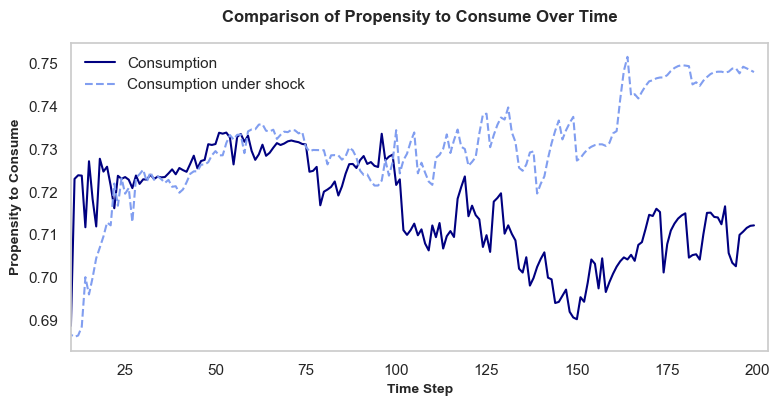

In [213]:
original_propensity = original_data['Propensity to Consume']
shocked_propensity = rate_shocked_model_data['Propensity to Consume']

mean_propensity_orig = [np.mean(p) if p else None for p in original_propensity]
mean_propensity_shock = [np.mean(p) if p else None for p in shocked_propensity]
 

overall_mean_prop = np.mean(mean_propensity_orig)
overall_mean_prop_shocked = np.mean(mean_propensity_shock)
print(f"The average propensity to consume in the original model is {overall_mean_prop}")
print(f"The average propensity to consume in the shocked model is {overall_mean_prop_shocked}")


log_overall_mean_wage_original = np.log(overall_mean_prop)
log_overall_mean_wage_shocked = np.log(overall_mean_prop_shocked)

plt.figure(figsize=(9, 4))
plt.plot(mean_propensity_shock, color = 'navy', label='Consumption')  
plt.plot(mean_propensity_orig, linestyle = '--', color='#819EF0', label='Consumption under shock') 
plt.title('Comparison of Propensity to Consume Over Time', fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Time Step',fontsize=10, fontweight='bold')
plt.ylabel('Propensity to Consume',fontsize=10, fontweight='bold')
#plt.ylim(0.6, 0.8)  
plt.xlim(10,203)
plt.grid(False)
plt.legend(frameon = False)

plt.savefig('consumption_comparison.png') 
plt.show()


**e) Effect on production of firms**

The average propensity to consume in the original model is 15.312685717859562
The average propensity to consume in the shocked model is 10.501854522645685


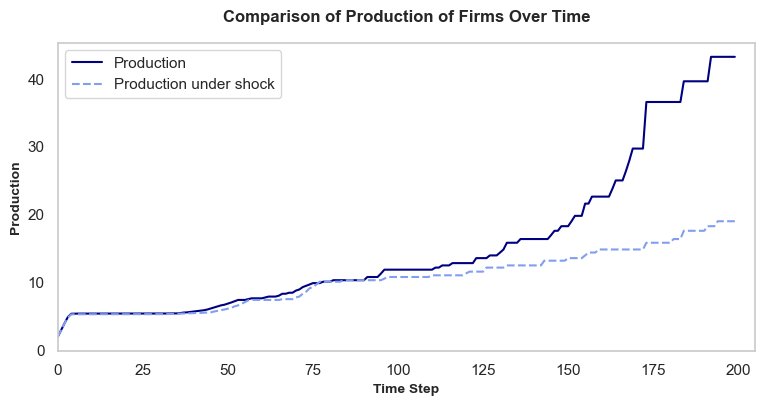

In [215]:

original_production = original_data['Production of Firms']
shocked_production = rate_shocked_model_data['Production of Firms']

mean_prod_orig = [np.mean(p) if p else None for p in original_production]
mean_prod_shock = [np.mean(p) if p else None for p in shocked_production]
 

overall_mean_prod = np.mean(mean_prod_orig)
overall_mean_prod_shocked = np.mean(mean_prod_shock)
print(f"The average propensity to consume in the original model is {overall_mean_prod}")
print(f"The average propensity to consume in the shocked model is {overall_mean_prod_shocked}")

# Apply logarithmic transformation to overall means
log_overall_mean_wage_original = np.log(overall_mean_prod)
log_overall_mean_wage_shocked = np.log(overall_mean_prod_shocked)


plt.figure(figsize=(9, 4))
plt.plot(mean_prod_orig, color = 'navy', label='Production') 
plt.plot(mean_prod_shock, linestyle = '--', color='#819EF0', label='Production under shock') 
plt.title('Comparison of Production of Firms Over Time',  fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Time Step',fontsize=10, fontweight='bold')
plt.ylabel('Production',fontsize=10, fontweight='bold')
plt.xlim(0, 205) 
plt.grid(False)
plt.legend()

plt.savefig('production_comparison.png') 
plt.show()

**f) Correlation plot**

In [216]:
print(rate_shocked_model_data['Price of Firms'])
print(rate_shocked_model_data['Real GDP'] )


rate_shocked_model_data['Price of Firms'] = rate_shocked_model_data['Price of Firms'].apply(lambda x: x[0])  # Assuming you want the first element of each list

rate_shocked_model_data['Real GDP'] = pd.to_numeric(rate_shocked_model_data['Nominal GDP'], errors='coerce')
rate_shocked_model_data = rate_shocked_model_data.dropna()

correlation_coefficient = rate_shocked_model_data['Price of Firms'].corr(rate_shocked_model_data['Nominal GDP'])

0      [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, ...
1      [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, ...
2      [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, ...
3      [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.4849999999999...
4      [1.5, 1.4849999999999999, 1.5, 1.5, 1.48499999...
                             ...                        
195    [4.091241397908621, 4.09205976894181, 4.092059...
196    [4.0941064127784985, 4.0941064127784985, 4.133...
197    [4.1338070867105, 4.132153811887707, 4.1362882...
198    [4.173058002471582, 4.176397951675346, 4.17472...
199    [4.213945666927686, 4.216053272000515, 4.21521...
Name: Price of Firms, Length: 200, dtype: object
0      192.000000
1      288.000000
2      382.514768
3      466.618273
4      510.182949
          ...    
195    713.881644
196    714.328756
197    713.845105
198    713.877594
199    713.879995
Name: Real GDP, Length: 200, dtype: float64


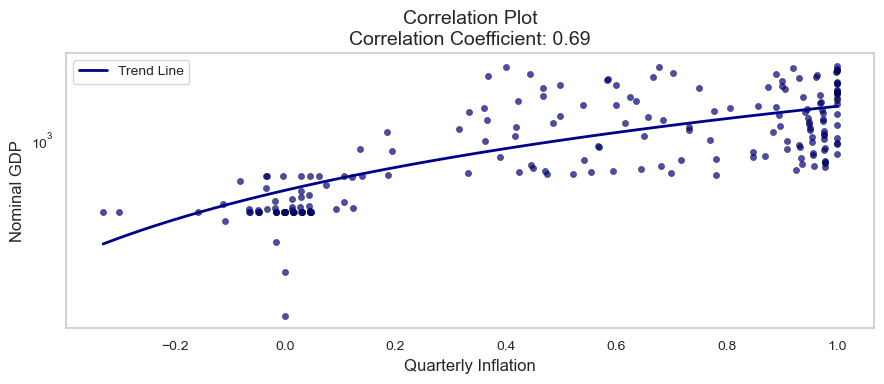

In [217]:

quarterly_inflation = rate_shocked_model_data['Quarterly Inflation']
nominal_gdp = rate_shocked_model_data['Nominal GDP']

slope, intercept, r_value, p_value, std_err = linregress(quarterly_inflation, nominal_gdp)

# Plot
plt.figure(figsize=(9, 4))
sns.set(style="whitegrid")

# Scatter plot
sns.scatterplot(x='Quarterly Inflation', y='Nominal GDP', data=rate_shocked_model_data, s=20, color='darkblue', edgecolor='black', alpha=0.7)

# Trend line
x_values = np.linspace(min(quarterly_inflation), max(quarterly_inflation), 100)
y_values = intercept + slope * x_values
plt.plot(x_values, y_values, color='darkblue', linewidth=2, label=f'Trend Line')
correlation_coefficient = rate_shocked_model_data['Quarterly Inflation'].corr(rate_shocked_model_data['Nominal GDP'])

plt.title(f'Correlation Plot\nCorrelation Coefficient: {correlation_coefficient:.2f}', fontsize=14)
plt.xlabel('Quarterly Inflation', fontsize=12)
plt.ylabel('Nominal GDP', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(False)
plt.yscale('log')


plt.tight_layout()
plt.show()

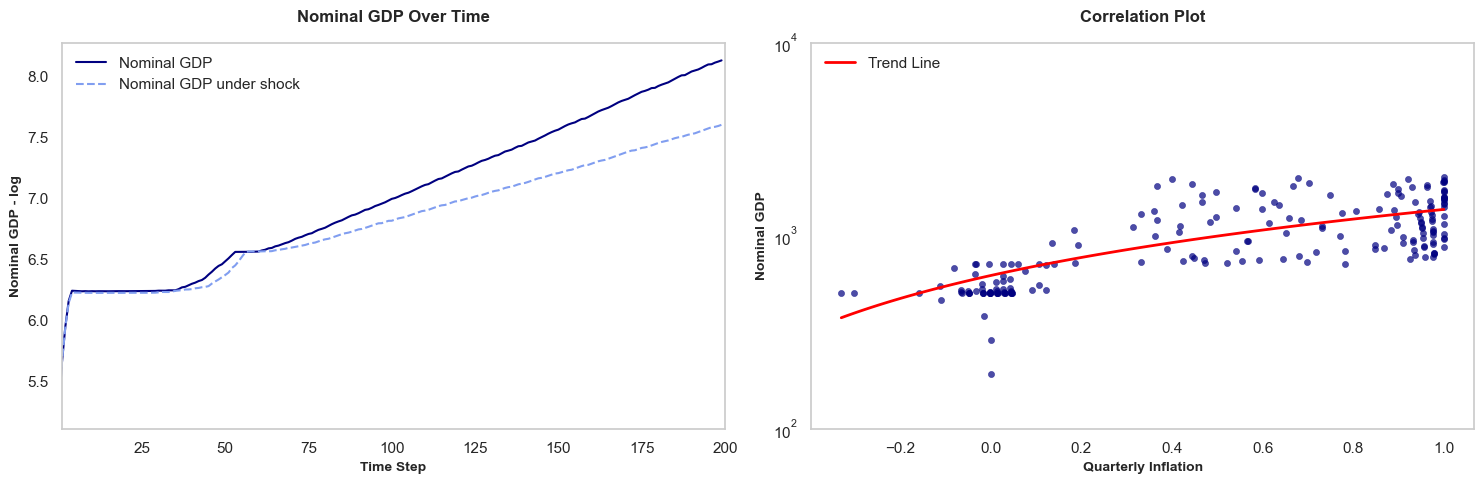

In [218]:
plt.figure(figsize=(15, 5))

# First subplot: Nominal GDP comparison
log_real_gdp_original = np.log(original_data["Nominal GDP"])
log_real_gdp_shock = np.log(rate_shocked_model_data["Nominal GDP"])

plt.subplot(1, 2, 1)
plt.plot(log_real_gdp_original, label='Nominal GDP', color='navy')
plt.plot(log_real_gdp_shock, label='Nominal GDP under shock', linestyle='--', color='#819EF0')
plt.xlabel('Time Step', fontsize=10, fontweight='bold')
plt.ylabel('Nominal GDP - log', fontsize=10, fontweight='bold')
plt.title('Nominal GDP Over Time', fontsize=12, fontweight='bold', pad=15)
plt.legend(frameon=False)
plt.xlim(1, 200)
plt.grid(False)

# Second subplot: Scatter plot and trend line for Quarterly Inflation vs Nominal GDP
plt.subplot(1, 2, 2)
sns.scatterplot(x='Quarterly Inflation', y='Nominal GDP', data=rate_shocked_model_data, s=20, color='navy', edgecolor='navy', alpha=0.7)
quarterly_inflation = rate_shocked_model_data['Quarterly Inflation']
nominal_gdp = rate_shocked_model_data['Nominal GDP']
slope, intercept, r_value, p_value, std_err = linregress(quarterly_inflation, nominal_gdp)
x_values = np.linspace(min(quarterly_inflation), max(quarterly_inflation), 100)
y_values = intercept + slope * x_values
plt.plot(x_values, y_values, color='red', linewidth=2, label=f'Trend Line')
plt.title(f'Correlation Plot', fontsize=12, fontweight='bold', pad=15)
plt.xlabel('Quarterly Inflation', fontsize=10, fontweight='bold')
plt.ylabel('Nominal GDP', fontsize=10, fontweight='bold')
plt.legend(frameon=False)
plt.legend(frameon=False, loc='upper left')
plt.yscale('log')
plt.grid(False)
plt.ylim(100, 10000)  # Set the y-axis limits to focus on 10^2 to 10^4
plt.tight_layout()
plt.savefig('comparison_plots_1.png')
plt.show()

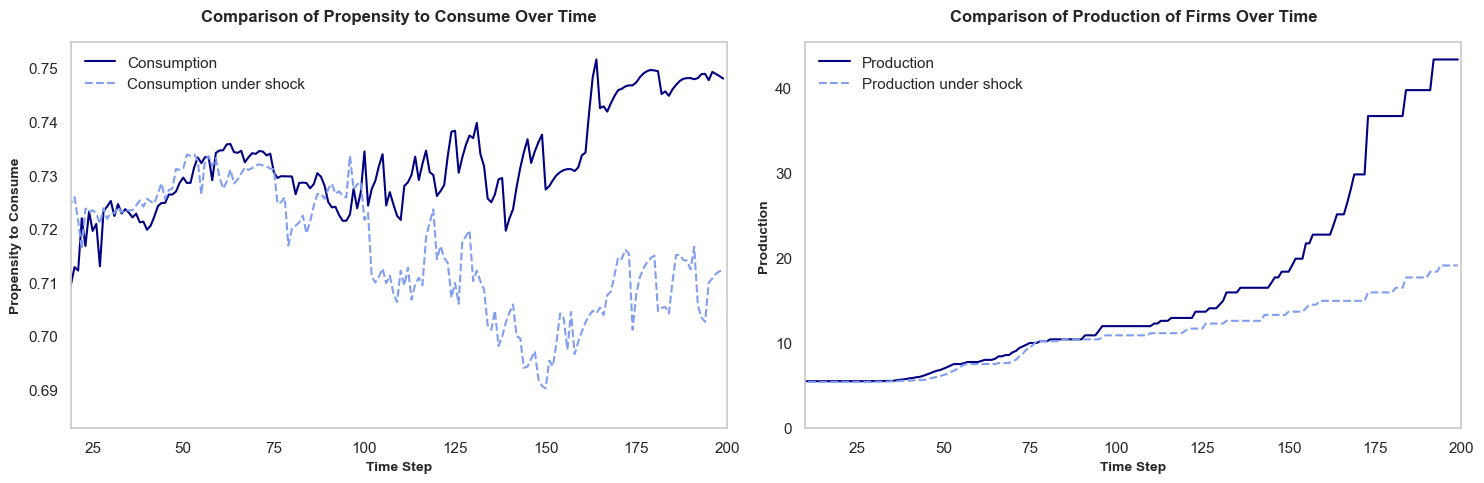

In [224]:
plt.figure(figsize=(15, 5))

# First subplot: Propensity to Consume comparison
original_propensity = original_data['Propensity to Consume']
shocked_propensity = rate_shocked_model_data['Propensity to Consume']

mean_propensity_orig = [np.mean(p) if p else None for p in original_propensity]
mean_propensity_shock = [np.mean(p) if p else None for p in shocked_propensity]

plt.subplot(1, 2, 1)
plt.plot(mean_propensity_shock, color='navy', label='Consumption')
plt.plot(mean_propensity_orig, linestyle='--', color='#819EF0', label='Consumption under shock')
plt.xlabel('Time Step', fontsize=10, fontweight='bold')
plt.ylabel('Propensity to Consume', fontsize=10, fontweight='bold')
plt.title('Comparison of Propensity to Consume Over Time', fontsize=12, fontweight='bold', pad=15)
plt.legend(frameon=False)
plt.xlim(19, 200)

plt.grid(False)

# Second subplot: Production of Firms comparison
original_production = original_data['Production of Firms']
shocked_production = rate_shocked_model_data['Production of Firms']

mean_prod_orig = [np.mean(p) if p else None for p in original_production]
mean_prod_shock = [np.mean(p) if p else None for p in shocked_production]

plt.subplot(1, 2, 2)
plt.plot(mean_prod_orig, color='navy', label='Production')
plt.plot(mean_prod_shock, linestyle='--', color='#819EF0', label='Production under shock')
plt.xlabel('Time Step', fontsize=10, fontweight='bold')
plt.ylabel('Production', fontsize=10, fontweight='bold')
plt.title('Comparison of Production of Firms Over Time', fontsize=12, fontweight='bold', pad=15)
plt.grid(False)
plt.xlim(10, 200)
plt.legend(frameon=False)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('comparison_plots_2.png')
plt.show()


**g) Effect on unemployment**

The mean_unemployment in the original model is 0.10444327731092436
The mean_unemployment in the shocked model is 0.12351890756302521


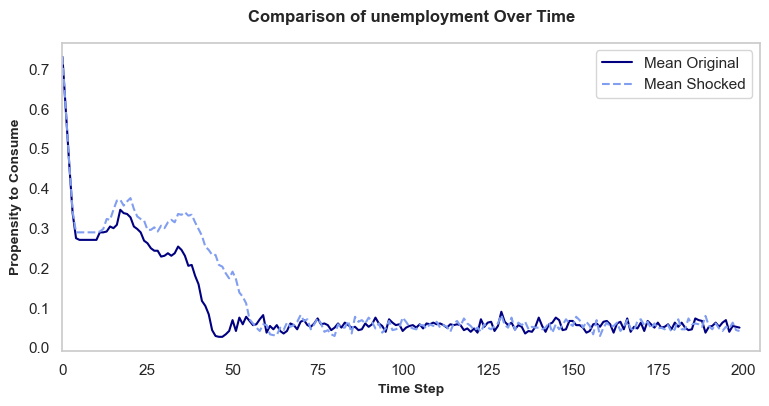

In [158]:
original_unemployment = original_data['Unemployment Rate']
shocked_unemployment = rate_shocked_model_data['Unemployment Rate']
mean_unemployment = np.mean(original_unemployment)
mean_unemployment_shocked = np.mean(shocked_unemployment)
print(f"The mean_unemployment in the original model is {mean_unemployment}")
print(f"The mean_unemployment in the shocked model is {mean_unemployment_shocked}")

plt.figure(figsize=(9, 4))
plt.plot(original_unemployment, color = 'navy', label='Mean Original')  
plt.plot(shocked_unemployment, '#819EF0', linestyle = '--', label='Mean Shocked') 
plt.title('Comparison of unemployment Over Time', fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Time Step',fontsize=10, fontweight='bold')
plt.ylabel('Propensity to Consume',fontsize=10, fontweight='bold')
plt.xlim(0, 205) 
plt.grid(False)
plt.legend()

plt.savefig('unemployment_comparison.png') 
plt.show()

**h) Effect on prices**

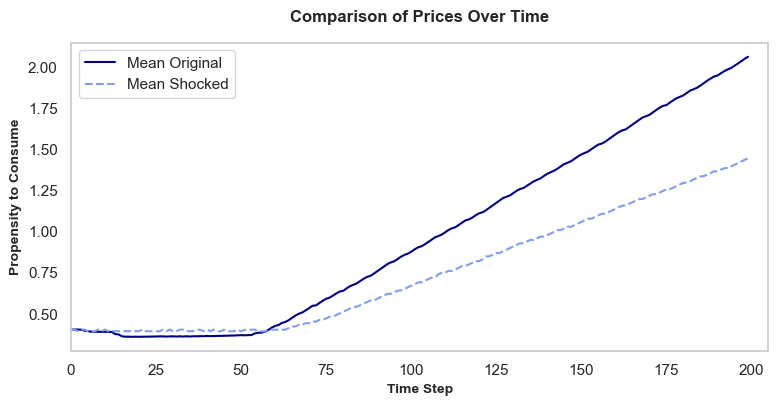

In [159]:
price_data_original = original_data['Price of Firms']
price_data_shocked = rate_shocked_model_data['Price of Firms']


mean_price_original = [np.mean(prices) for prices in price_data_original]
mean_price_shocked = [np.mean(prices) for prices in price_data_shocked]

log_mean_price_original = np.log(mean_price_original)
log_mean_price_shocked = np.log(mean_price_shocked)

# Plot
plt.figure(figsize=(9, 4))
plt.plot(log_mean_price_original, color = 'navy', label='Mean Original')  
plt.plot(log_mean_price_shocked, '#819EF0', linestyle = '--', label='Mean Shocked') 
plt.title('Comparison of Prices Over Time', fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Time Step', fontsize=10, fontweight='bold')
plt.ylabel('Propensity to Consume',fontsize=10, fontweight='bold')
plt.xlim(0,205)
plt.grid(False)
plt.legend()

plt.savefig('price_comparison.png') 
plt.show()


#### 4.2 Minimum wage policy

In [160]:
wage_shocked_model = EconomyModel(num_firms=64, num_workers=476, num_banks=10, base_price=1.5, base_savings=2, wage_shock=0.1, price_shock=0.02, interest_shock=0.01, interest_rate_policy_rbar = 0.05, production_shock=0.01, base_wage = 1.5)

for i in range(num_steps):
    wage_shocked_model.step()

    
wage_shocked_model_data = wage_shocked_model.datacollector.get_model_vars_dataframe()
wage_shocked_agent_data = wage_shocked_model.datacollector.get_agent_vars_dataframe()

**a) Effect on GDP** 

In [161]:
gdp_original = original_data["Real GDP"]
print(gdp_original)
real_gdp_shock = wage_shocked_model_data["Real GDP"]
print(real_gdp_shock)

avg_gdp = np.max(gdp_original) 
print(f"The mean Real GDP in the original model is {round(avg_gdp,2)} ")

avg_gdp_shock = np.max(real_gdp_shock) 
print(f"The mean Real GDP in the shocked is {round(avg_gdp_shock,2)} ")

0      192.000000
1      288.000000
2      384.000000
3      472.603833
4      517.758994
          ...    
195    714.581453
196    714.009651
197    714.007288
198    714.420173
199    714.479245
Name: Real GDP, Length: 200, dtype: float64
0      192.000000
1      288.000000
2      382.529540
3      472.584201
4      558.101980
          ...    
195    714.068528
196    714.040215
197    714.566632
198    713.322404
199    714.037209
Name: Real GDP, Length: 200, dtype: float64
The mean Real GDP in the original model is (716.3554527692161, 2) 
The mean Real GDP in the shocked is (715.6094711115899, 2) 


The maximum Real GDP in the original model is 8.232858902274128
The maximum Real GDP in the shocked model is 9.242489472962978


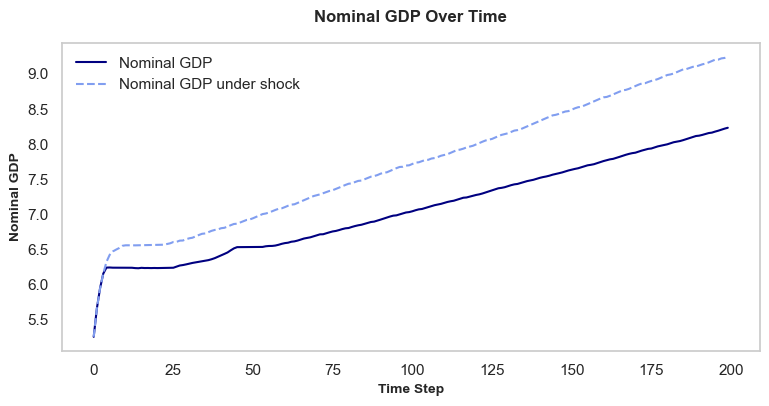

In [162]:
log_real_gdp_original = np.log(original_data["Nominal GDP"])
log_real_gdp_shock = np.log(wage_shocked_model_data["Nominal GDP"])

max_log_gdp_original = np.max(log_real_gdp_original)
max_log_gdp_shock = np.max(log_real_gdp_shock)

print(f"The maximum Real GDP in the original model is {max_log_gdp_original}")
print(f"The maximum Real GDP in the shocked model is {max_log_gdp_shock}")

plt.figure(figsize=(9, 4))


plt.plot(log_real_gdp_original, label='Nominal GDP', color='navy')
plt.plot(log_real_gdp_shock, label='Nominal GDP under shock', linestyle='--',color='#819EF0')
plt.xlabel('Time Step', fontsize=10, fontweight='bold')
plt.grid(False)
plt.ylabel('Nominal GDP', fontsize=10, fontweight='bold')
plt.title('Nominal GDP Over Time', fontsize=12, fontweight='bold',pad=15)
plt.legend(frameon = False)

plt.savefig('gdp_comparison_wage.png') 
plt.show()

**b) Effect on Inflation**

The annualized inflation for the original model is 3.21%
The annualized inflation for the comparison model is 5.62%


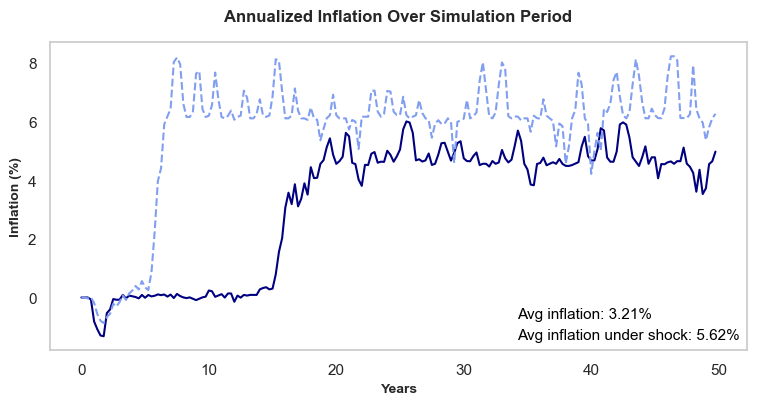

In [791]:
mean_annualized_original = np.mean(original_data['Annualized Inflation'])
mean_annualized_comparison = np.mean(wage_shocked_model_data['Annualized Inflation'])

print(f'The annualized inflation for the original model is {round(mean_annualized_original, 2)}%')
print(f'The annualized inflation for the comparison model is {round(mean_annualized_comparison, 2)}%')

num_steps = len(original_data)
quarters = np.arange(num_steps)
years = quarters / 4  


plt.figure(figsize=(9, 4))
plt.plot(years, original_data['Annualized Inflation'], color='navy')
plt.plot(years, wage_shocked_model_data['Annualized Inflation'], linestyle = '--', color='#819EF0')
plt.title('Annualized Inflation Over Simulation Period',  fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Years',fontsize=10, fontweight='bold')
plt.ylabel('Inflation (%)',fontsize=10, fontweight='bold')
plt.grid(False)

plt.text(0.67, 0.14, f'Avg inflation: {round(mean_annualized_original, 2)}%', 
         ha='left', va='top', transform=plt.gca().transAxes, fontsize=11, color='black')
plt.text(0.67, 0.07, f'Avg inflation under shock: {round(mean_annualized_comparison, 2)}%', 
         ha='left', va='top', transform=plt.gca().transAxes, fontsize=11, color='black')


plt.savefig('inflation_comparison_wage.png') 
plt.show() 

**c) Effect on wages**

In [163]:
wage_data_original = original_data['Wage Offered']
wage_data_shocked = wage_shocked_model_data['Wage Offered']


mean_wage_original = [np.mean(wages) for wages in wage_data_original]

mean_wage_shocked = [np.mean(wages) for wages in wage_data_shocked]

overall_mean_wage_original = np.mean(mean_wage_original)
overall_mean_wage_shocked = np.mean(mean_wage_shocked)
print(f"The average offered wage in the original model is {overall_mean_wage_original}")
print(f"The average offered wage in the shocked model is {overall_mean_wage_shocked}")

The average offered wage in the original model is 187.88374771445822
The average offered wage in the shocked model is 901849.9377755373


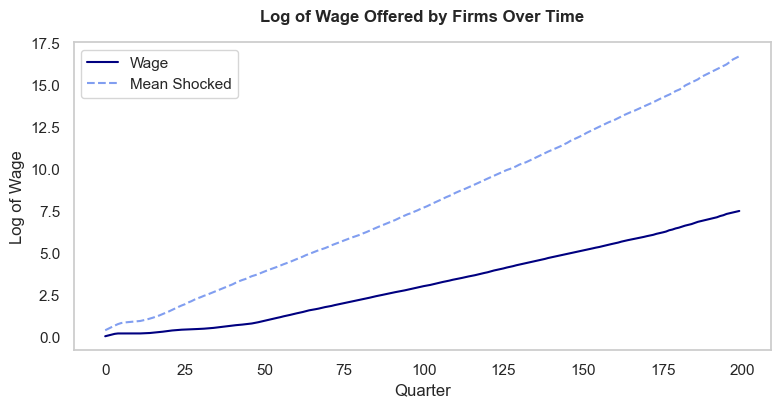

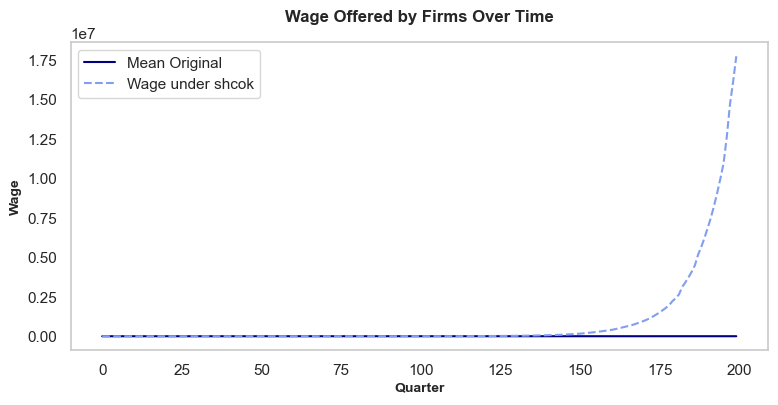

In [179]:

# Apply logarithmic transformation to each
log_mean_wage_original = np.log(mean_wage_original)
log_mean_wage_shocked = np.log(mean_wage_shocked)
# Apply logarithmic transformation to overall means
log_overall_mean_wage_original = np.log(overall_mean_wage_original)
log_overall_mean_wage_shocked = np.log(overall_mean_wage_shocked)

# Plot
plt.figure(figsize=(9, 4))
plt.plot(log_mean_wage_original, 'navy', label='Wage')
plt.plot(log_mean_wage_shocked, linestyle = '--', color='#819EF0', label='Mean Shocked')
plt.title('Log of Wage Offered by Firms Over Time', fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Quarter')
plt.ylabel('Log of Wage')
plt.grid(False)
plt.legend()

plt.show()


# Plot
plt.figure(figsize=(9, 4))
plt.plot(mean_wage_original, 'navy', label='Mean Original')
plt.plot(mean_wage_shocked, linestyle = '--', color='#819EF0',  label='Wage under shcok')
plt.title('Wage Offered by Firms Over Time',  fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Quarter',fontsize=10, fontweight='bold')
plt.ylabel('Wage', fontsize=10, fontweight='bold')
plt.grid(False)
plt.legend()

plt.savefig('wage_comparison_wage.png') 
plt.show()


**d) Effect on propensity to consume**

The average propensity to consume in the original model is 0.7197128390031543
The average propensity to consume in the shocked model is 0.7330876191503165


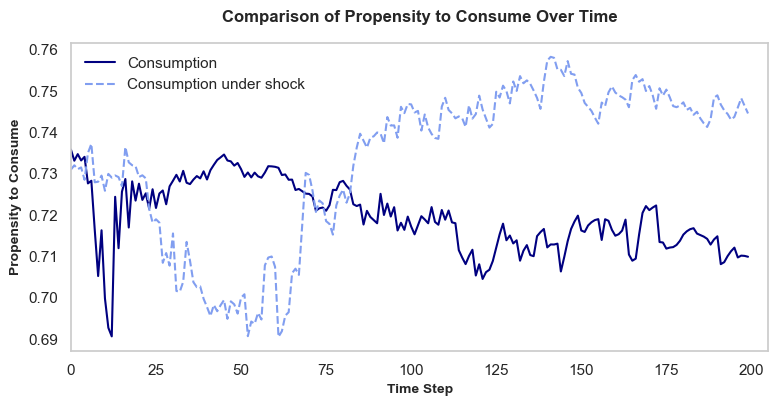

In [178]:
original_propensity = original_data['Propensity to Consume']
shocked_propensity = wage_shocked_model_data['Propensity to Consume']

mean_propensity_orig = [np.mean(p) if p else None for p in original_propensity]
mean_propensity_shock = [np.mean(p) if p else None for p in shocked_propensity]
 

overall_mean_prop = np.mean(mean_propensity_orig)
overall_mean_prop_shocked = np.mean(mean_propensity_shock)
print(f"The average propensity to consume in the original model is {overall_mean_prop}")
print(f"The average propensity to consume in the shocked model is {overall_mean_prop_shocked}")

log_overall_mean_wage_original = np.log(overall_mean_prop)
log_overall_mean_wage_shocked = np.log(overall_mean_prop_shocked)

plt.figure(figsize=(9, 4))
plt.plot(mean_propensity_orig, color = 'navy', label='Consumption')  
plt.plot(mean_propensity_shock, linestyle = '--', color='#819EF0', label='Consumption under shock') 
plt.title('Comparison of Propensity to Consume Over Time', fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Time Step',fontsize=10, fontweight='bold')
plt.ylabel('Propensity to Consume',fontsize=10, fontweight='bold')
#plt.ylim(0.6, 0.8)  
plt.xlim(0,205)
plt.grid(False)
plt.legend(frameon = False)

plt.savefig('consumption_comparison_wage.png') 
plt.show()

**e) Effect on production of firms**

The average propensity to consume in the original model is 11.383054464382084
The average propensity to consume in the shocked model is 16.98762160963418


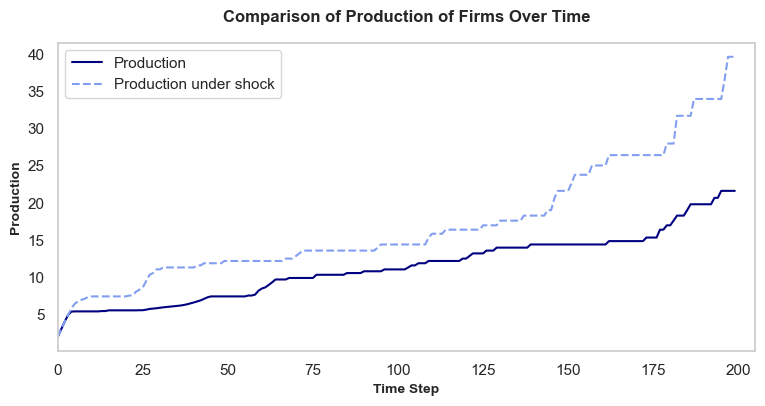

In [166]:
original_production = original_data['Production of Firms']
shocked_production = wage_shocked_model_data['Production of Firms']

mean_prod_orig = [np.mean(p) if p else None for p in original_production]
mean_prod_shock = [np.mean(p) if p else None for p in shocked_production]
 

overall_mean_prod = np.mean(mean_prod_orig)
overall_mean_prod_shocked = np.mean(mean_prod_shock)
print(f"The average propensity to consume in the original model is {overall_mean_prod}")
print(f"The average propensity to consume in the shocked model is {overall_mean_prod_shocked}")

# Apply logarithmic transformation to overall means
log_overall_mean_wage_original = np.log(overall_mean_prod)
log_overall_mean_wage_shocked = np.log(overall_mean_prod_shocked)


plt.figure(figsize=(9, 4))
plt.plot(mean_prod_orig, color = 'navy', label='Production') 
plt.plot(mean_prod_shock, linestyle = '--', color='#819EF0', label='Production under shock') 
plt.title('Comparison of Production of Firms Over Time',  fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Time Step',fontsize=10, fontweight='bold')
plt.ylabel('Production',fontsize=10, fontweight='bold')
plt.xlim(0, 205) 
plt.grid(False)
plt.legend()

plt.savefig('production_comparison_wage.png') 
plt.show()

**f) Economic indicators**

The maximum Real GDP in the original model is 8.232858902274128
The maximum Real GDP in the shocked model is 9.242489472962978
The average propensity to consume in the original model is 0.7197128390031543
The average propensity to consume in the shocked model is 0.7330876191503165
The average propensity to consume in the original model is 11.383054464382084
The average propensity to consume in the shocked model is 16.98762160963418


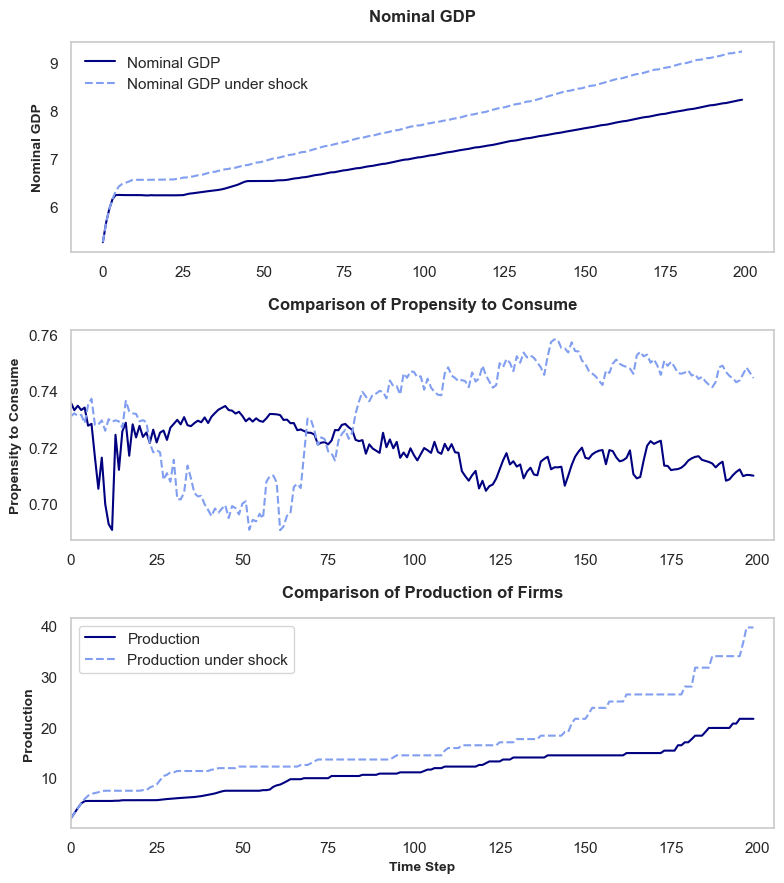

In [188]:
log_real_gdp_original = np.log(original_data["Nominal GDP"])
log_real_gdp_shock = np.log(wage_shocked_model_data["Nominal GDP"])


max_log_gdp_original = np.max(log_real_gdp_original)
max_log_gdp_shock = np.max(log_real_gdp_shock)

print(f"The maximum Real GDP in the original model is {max_log_gdp_original}")
print(f"The maximum Real GDP in the shocked model is {max_log_gdp_shock}")

plt.figure(figsize=(8, 9))

# subplot 1
plt.subplot(3, 1, 1)
plt.plot(log_real_gdp_original, label='Nominal GDP', color='navy')
plt.plot(log_real_gdp_shock, label='Nominal GDP under shock', linestyle='--',color='#819EF0')

plt.grid(False)
plt.ylabel('Nominal GDP', fontsize=10, fontweight='bold')
plt.title('Nominal GDP', fontsize=12, fontweight='bold',pad=15)
plt.legend(frameon = False)

# subplot 2
plt.subplot(3, 1, 2)
original_propensity = original_data['Propensity to Consume']
shocked_propensity = wage_shocked_model_data['Propensity to Consume']
mean_propensity_orig = [np.mean(p) if p else None for p in original_propensity]
mean_propensity_shock = [np.mean(p) if p else None for p in shocked_propensity]
 

overall_mean_prop = np.mean(mean_propensity_orig)
overall_mean_prop_shocked = np.mean(mean_propensity_shock)
print(f"The average propensity to consume in the original model is {overall_mean_prop}")
print(f"The average propensity to consume in the shocked model is {overall_mean_prop_shocked}")


log_overall_mean_wage_original = np.log(overall_mean_prop)
log_overall_mean_wage_shocked = np.log(overall_mean_prop_shocked)


plt.plot(mean_propensity_orig, color = 'navy', label='Consumption')  
plt.plot(mean_propensity_shock, linestyle = '--', color='#819EF0', label='Consumption under shock') 
plt.title('Comparison of Propensity to Consume', fontsize=12, fontweight='bold',pad=15)
#plt.xlabel('Time Step',fontsize=10, fontweight='bold')
plt.ylabel('Propensity to Consume',fontsize=10, fontweight='bold')
#plt.ylim(0.6, 0.8)  
plt.xlim(0,205)
plt.grid(False)


original_production = original_data['Production of Firms']
shocked_production = wage_shocked_model_data['Production of Firms']

mean_prod_orig = [np.mean(p) if p else None for p in original_production]
mean_prod_shock = [np.mean(p) if p else None for p in shocked_production]
 

overall_mean_prod = np.mean(mean_prod_orig)
overall_mean_prod_shocked = np.mean(mean_prod_shock)
print(f"The average production in the original model is {overall_mean_prod}")
print(f"The average production to consume in the shocked model is {overall_mean_prod_shocked}")


log_overall_mean_wage_original = np.log(overall_mean_prod)
log_overall_mean_wage_shocked = np.log(overall_mean_prod_shocked)

plt.subplot(3, 1, 3)
plt.plot(mean_prod_orig, color = 'navy', label='Production') 
plt.plot(mean_prod_shock, linestyle = '--', color='#819EF0', label='Production under shock') 
plt.title('Comparison of Production of Firms',  fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Time Step',fontsize=10, fontweight='bold')
plt.ylabel('Production',fontsize=10, fontweight='bold')
plt.xlim(0, 205) 
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.savefig('omparison_wage_shock.png') 
plt.show()

**g) Effect on unemployment**

The mean_unemployment in the original model is 0.10444327731092436
The mean_unemployment in the shocked model is 0.0658718487394958


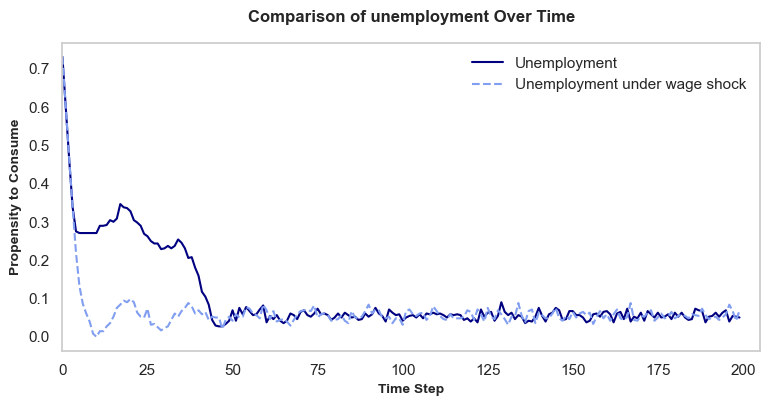

In [169]:
original_unemployment = original_data['Unemployment Rate']
shocked_unemployment = wage_shocked_model_data['Unemployment Rate']
mean_unemployment = np.mean(original_unemployment)
mean_unemployment_shocked = np.mean(shocked_unemployment)
print(f"The mean_unemployment in the original model is {mean_unemployment}")
print(f"The mean_unemployment in the shocked model is {mean_unemployment_shocked}")

plt.figure(figsize=(9, 4))
plt.plot(original_unemployment, color = 'navy', label='Unemployment')  
plt.plot(shocked_unemployment, '#819EF0', linestyle = '--', label='Unemployment under wage shock') 
plt.title('Comparison of unemployment Over Time', fontsize=12, fontweight='bold',pad=15)
plt.xlabel('Time Step',fontsize=10, fontweight='bold')
plt.ylabel('Propensity to Consume',fontsize=10, fontweight='bold')
plt.xlim(0, 205) 
plt.grid(False)
plt.legend(frameon = False)

plt.savefig('unemployment_comparison_wage.png') 
plt.show()

**h) Effect on wealth distribution**

In [170]:
income = wage_shocked_agent_data ["Income"]
end_income = income.xs(99, level="Step")  
print(end_income.head())  
end_income = end_income.dropna()  

wealth = wage_shocked_agent_data ["Wealth"]
end_wealth = wealth.xs(99, level="Step")  
print(end_wealth.head())  
end_wealth = end_wealth.dropna()  


income_skewness = skew(end_income.dropna()) 
print("Skewness of income distribution:", income_skewness)
wealth_skewness = skew(end_wealth.dropna()) 
print("Skewness of wealth distribution:", wealth_skewness)

AgentID
271    1076.927668
492    1303.082479
442     809.111697
213     668.687353
136    4948.453544
Name: Income, dtype: float64
AgentID
271    22272.232249
492    15528.210561
442    16933.205697
213    15919.446535
136    13625.399372
Name: Wealth, dtype: float64
Skewness of income distribution: 1.5684452237947195
Skewness of wealth distribution: -0.7775713533534918


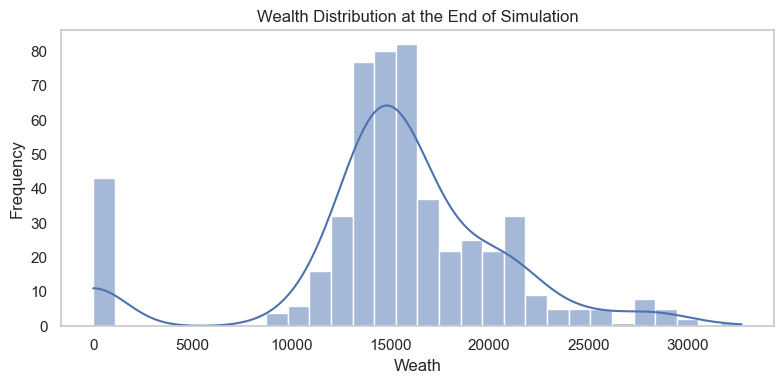

In [176]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))  
sns.histplot(end_wealth, kde=True)
plt.title('Wealth Distribution at the End of Simulation')
plt.xlabel('Weath')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()

plt.savefig('distribution_comparison_wage.png') 
plt.show()
